In [16]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from pathlib import Path

In [17]:
# IMPORTAZIONE DEL DATASET
train_dir = Path("/home/davide/Documenti/Uni/Percezione/progetto/A. RFMiD_All_Classes_Dataset/Train Set Simplified 2")
validation_dir = Path("/home/davide/Documenti/Uni/Percezione/progetto/A. RFMiD_All_Classes_Dataset/Validation Set Simplified 2")
test_dir= Path("/home/davide/Documenti/Uni/Percezione/progetto/A. RFMiD_All_Classes_Dataset/Test Set Simplified 2")
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_ds = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)
validation_ds = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)
test_ds = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1519 files belonging to 2 classes.
Found 506 files belonging to 2 classes.
Found 506 files belonging to 2 classes.


In [18]:
#VERIFICA NOME DELLE CLASSI IMPORTATE
class_names = train_ds.class_names
print(class_names)


['ARMD', 'OTHER']


In [19]:
"""
La funzione tf.data.autotune si occupa di ottimizzare la velocità di caricamento dei dati e l'uso della CPU o della GPU,
in base alle risorse disponibili e alle caratteristiche del sistema.

Quando si utilizza autotune, TensorFlow utilizza tecniche come la pre-fetching, il buffering e il parallelismo
per migliorare l'efficienza complessiva della pipeline dei dati. 
Ad esempio, può pre-caricare in anticipo i dati dal disco o dalla rete, 
in modo che siano pronti per essere utilizzati quando il modello è pronto per elaborarli.
"""
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [20]:
"""
la normalizzazione dei dati è una pratica comune
per garantire che le caratteristiche o i pixel di input abbiano
una scala coerente o un intervallo di valori appropriato per l'addestramento del modello

In questo caso si applica al dataset di immagini, in modo che i valori dei pixel che possono andare da 0 a 255
saranno portati all'intervallo [0,1)
"""
#normalization_layer = layers.Rescaling(1./255)


"\nla normalizzazione dei dati è una pratica comune\nper garantire che le caratteristiche o i pixel di input abbiano\nuna scala coerente o un intervallo di valori appropriato per l'addestramento del modello\n\nIn questo caso si applica al dataset di immagini, in modo che i valori dei pixel che possono andare da 0 a 255\nsaranno portati all'intervallo [0,1)\n"

In [21]:
"""
applicare trasformazioni casuali e realistiche ai dati di addestramento esistenti 
per creare nuovi campioni di addestramento
"""
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(IMG_SIZE[0],
                                  IMG_SIZE[1],
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)


In [33]:

num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [34]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [35]:
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 160, 160, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 160, 160, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 80, 80, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 80, 80, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 40, 40, 32)       0         
 g2D)                                                 

In [36]:
# Applico un peso alle classi che verrà passato in model.fit in base alla rispettiva grandezza del loro dataset
imgfolder0 = Path(f"{train_dir}/ARMD")
imgfolder1 = Path(f"{train_dir}/OTHER")
image_count0 = len(list(imgfolder0.glob('*.png')))
image_count1 = len(list(imgfolder1.glob('*.png')))
weight_for_0 = (image_count0+image_count1)/image_count0
weight_for_1 = (image_count0+image_count1)/image_count1

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 15.19
Weight for class 1: 1.07


In [37]:

epochs = 15
history = model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=epochs,
  class_weight=class_weight
)


Epoch 1/15


2023-06-12 12:08:43.891648: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1519]
	 [[{{node Placeholder/_4}}]]
2023-06-12 12:08:43.892058: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1519]
	 [[{{node Placeholder/_0}}]]


48/48 [==============================] - ETA: 0s - loss: 1.4622 - accuracy: 0.2804

2023-06-12 12:09:02.250235: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [506]
	 [[{{node Placeholder/_4}}]]
2023-06-12 12:09:02.250528: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [506]
	 [[{{node Placeholder/_0}}]]


48/48 [==============================] - 34s 692ms/step - loss: 1.4622 - accuracy: 0.2804 - val_loss: 0.6983 - val_accuracy: 0.1265
Epoch 2/15
48/48 [==============================] - 32s 670ms/step - loss: 1.3874 - accuracy: 0.3733 - val_loss: 0.6749 - val_accuracy: 0.8656
Epoch 3/15
48/48 [==============================] - 33s 701ms/step - loss: 1.3858 - accuracy: 0.3673 - val_loss: 0.6143 - val_accuracy: 0.9051
Epoch 4/15
48/48 [==============================] - 35s 728ms/step - loss: 1.3853 - accuracy: 0.5431 - val_loss: 0.6450 - val_accuracy: 0.8636
Epoch 5/15
48/48 [==============================] - 33s 696ms/step - loss: 1.3659 - accuracy: 0.6847 - val_loss: 0.7397 - val_accuracy: 0.3617
Epoch 6/15
48/48 [==============================] - 35s 726ms/step - loss: 1.3559 - accuracy: 0.5016 - val_loss: 0.8730 - val_accuracy: 0.2174
Epoch 7/15
48/48 [==============================] - 33s 693ms/step - loss: 1.3564 - accuracy: 0.6596 - val_loss: 0.4503 - val_accuracy: 0.8953
Epoch 8/15

In [47]:
fine_tune_epochs = 10
total_epochs =  epochs + fine_tune_epochs
history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,
                         class_weight=class_weight)

Epoch 15/25


2023-05-30 17:50:37.416143: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1519]
	 [[{{node Placeholder/_4}}]]
2023-05-30 17:50:37.416805: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_17' with dtype int32 and shape [2]
	 [[{{node Placeholder/_17}}]]
2023-05-30 17:50:47.818453: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 193 of 256
2023-05-30 17:50:50.909816: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


48/48 [==============================] - ETA: 0s - loss: 1.4102 - accuracy: 0.5253

2023-05-30 17:52:12.741181: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 206 of 256
2023-05-30 17:52:14.920799: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


48/48 [==============================] - 111s 2s/step - loss: 1.4102 - accuracy: 0.5253 - val_loss: 0.6508 - val_accuracy: 0.7233
Epoch 16/25


2023-05-30 17:52:38.387351: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 193 of 256
2023-05-30 17:52:41.379278: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


48/48 [==============================] - ETA: 0s - loss: 1.4888 - accuracy: 0.3107

2023-05-30 17:54:03.713526: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 198 of 256
2023-05-30 17:54:06.102473: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


48/48 [==============================] - 111s 2s/step - loss: 1.4888 - accuracy: 0.3107 - val_loss: 0.7591 - val_accuracy: 0.2253
Epoch 17/25


2023-05-30 17:54:29.535172: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 193 of 256
2023-05-30 17:54:32.674414: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


48/48 [==============================] - ETA: 0s - loss: 1.3722 - accuracy: 0.2488

2023-05-30 17:55:55.781912: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 177 of 256
2023-05-30 17:55:59.295007: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


48/48 [==============================] - 114s 2s/step - loss: 1.3722 - accuracy: 0.2488 - val_loss: 0.6357 - val_accuracy: 0.5949
Epoch 18/25


2023-05-30 17:56:24.105648: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 162 of 256
2023-05-30 17:56:29.541576: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


48/48 [==============================] - ETA: 0s - loss: 1.3321 - accuracy: 0.4608

2023-05-30 17:57:53.317680: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 193 of 256
2023-05-30 17:57:56.383148: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


48/48 [==============================] - 117s 2s/step - loss: 1.3321 - accuracy: 0.4608 - val_loss: 0.5436 - val_accuracy: 0.8024
Epoch 19/25


2023-05-30 17:58:20.487835: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 201 of 256
2023-05-30 17:58:23.403330: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


48/48 [==============================] - ETA: 0s - loss: 1.2814 - accuracy: 0.5352

2023-05-30 17:59:47.504692: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 198 of 256
2023-05-30 17:59:49.927997: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


48/48 [==============================] - 113s 2s/step - loss: 1.2814 - accuracy: 0.5352 - val_loss: 0.7881 - val_accuracy: 0.5336
Epoch 20/25


2023-05-30 18:00:13.102485: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 193 of 256
2023-05-30 18:00:16.284288: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


48/48 [==============================] - ETA: 0s - loss: 1.3074 - accuracy: 0.5135

2023-05-30 18:01:40.436541: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 206 of 256
2023-05-30 18:01:42.631222: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


KeyboardInterrupt: 

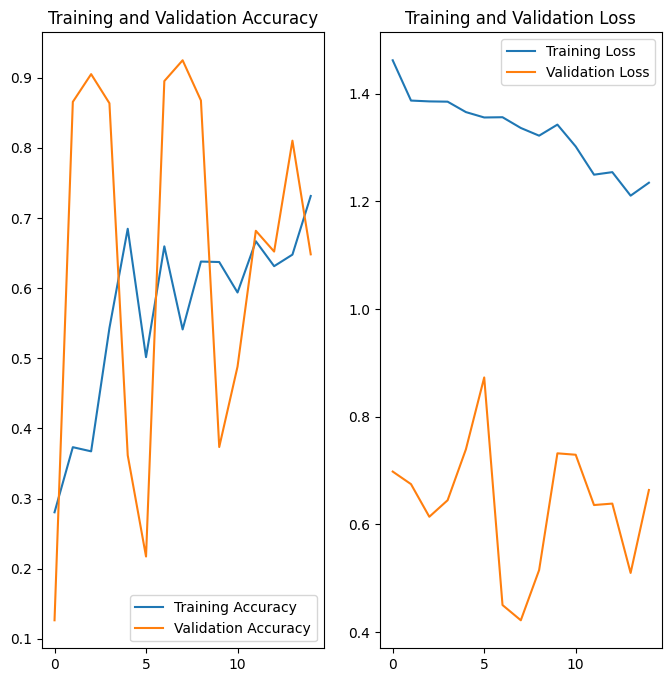

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch

2023-06-12 12:33:49.585614: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [506]
	 [[{{node Placeholder/_4}}]]
2023-06-12 12:33:49.586274: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [506]
	 [[{{node Placeholder/_0}}]]
2023-06-12 12:33:58.832126: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [32,160,1

Predictions:
 [1 0 1 0 0 1 1 0 1 0 0 1 0 1 1 0 0 1 0 0 0 1 0 0 0 1 1 0 0 0 0 1 0 1 1 0 0
 1 0 0 1 0 1 0 1 0 0 1 0 1 0 1 1 0 0 1 1 0 0 0 0 0 0 1]
Labels:
 [1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1]


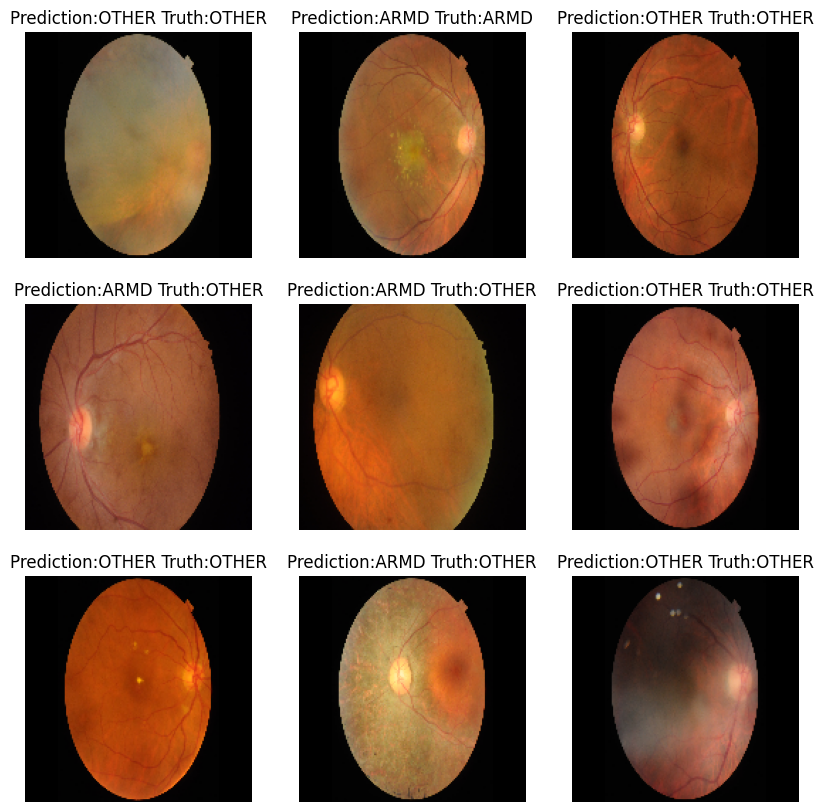

In [40]:
# Retrieve a batch of images from the test set
subset = test_ds.take(32)
image_batch, label_batch = subset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(f"Prediction:{class_names[predictions[i]]} Truth:{class_names[label_batch[i]]}")
  plt.axis("off")